[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/deep_learning/computer_vision/variational_auto_encoder/Vanilla_VAE.ipynb)

# Vanilla VAE (MNIST dataset)

In [ ]:
# --------------------------------------------------
# Instllation
# --------------------------------------------------
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10

In [ ]:
# --------------------------------------------------
# Device
# --------------------------------------------------
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

!nvidia-smi

cpu
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 150
epochs = 50
lr = 1e-3
weight_decay = 0

In [ ]:
# --------------------------------------------------
# Dataset
# --------------------------------------------------

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Datset
train_dataset = torchvision.datasets.MNIST(root = './train', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST(root = './test', train = False, transform = transform, download = True)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15897128.03it/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481094.29it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4365682.39it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3201231.52it/s]


Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15816000.86it/s]


Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474158.70it/s]


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3768662.50it/s]


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2792513.74it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



In [ ]:
# --------------------------------------------------
# Model
# --------------------------------------------------

class UnFlatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.view(-1, input.size()[-1], 1, 1)

class VanillaVAE(nn.Module):
    def __init__(self, d_latent):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride = 1, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride = 2, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, stride = 2, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Fully connected layer
        self.fc_mu = nn.Linear(128, d_latent)
        self.fc_logvar = nn.Linear(128, d_latent)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_latent, 128),
            UnFlatten(),
            nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(logvar)
        z = mu + (eps*std)
        return z

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        # Reparametarize
        z = self.reparameterize(mu, logvar)
        # Decode
        decoded_x = self.decoder(z)
        return decoded_x, mu, logvar

In [ ]:
# --------------------------------------------------
# Loss function
# --------------------------------------------------

class VAELoss(nn.Module):
    def __init__(self, KLDWeight = 1):
        super().__init__()
        self.KLDWeight = KLDWeight

    def forward(self, decoded_input, input, mu, logvar):
        BCE = F.binary_cross_entropy(decoded_input, input, reduction = 'sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.KLDWeight*KLD

In [ ]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = VanillaVAE(32)
model = model.to(device)

# Loss function
criterion = VAELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

[Epoch 50/50]: 100%|██████████| 400/400 [00:12<00:00, 33.10it/s]


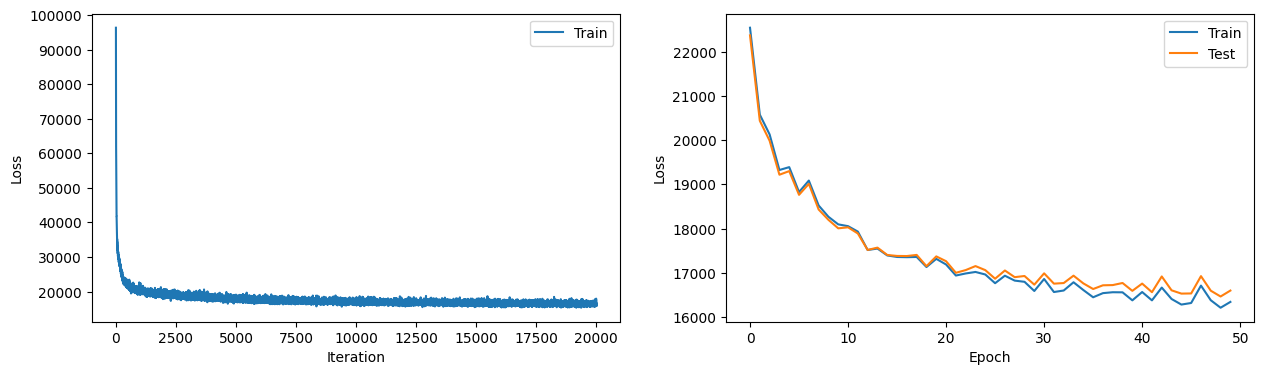

In [ ]:
# --------------------------------------------------
# Training
# --------------------------------------------------

train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []
for epoch in range(epochs):

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch {epoch+1}/{epochs}]')

        # Training step
        model.train()
        for x, _ in pbar:
            x = x.to(device)
            decoded_x, mu, logvar = model(x)
            loss = criterion(decoded_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_minibatch.append(loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            # Train loss
            losses = []
            for x, _ in train_loader:
                x = x.to(device)
                decoded_x, mu, logvar = model(x)
                loss = criterion(decoded_x, x, mu, logvar)
                losses.append(loss.item())
            train_loss_epoch.append(np.mean(losses))

            # Test loss
            losses = []
            for x, _ in test_loader:
                x = x.to(device)
                decoded_x, mu, logvar = model(x)
                loss = criterion(decoded_x, x, mu, logvar)
                losses.append(loss.item())
            test_loss_epoch.append(np.mean(losses))

# Loss plot
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(train_loss_epoch, label = "Train")
ax[1].plot(test_loss_epoch, label = "Test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.show()

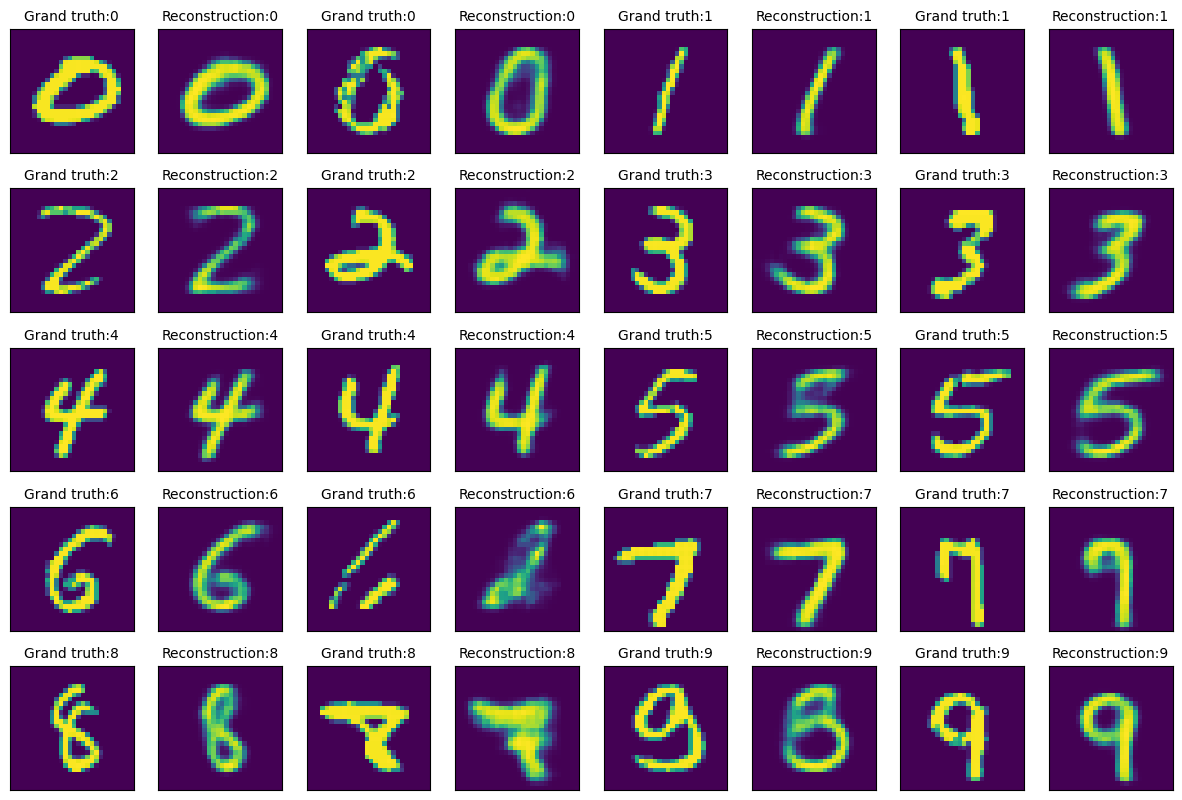

In [ ]:
# --------------------------------------------------
# Plot reconstruction image
# --------------------------------------------------

# Reconstruction
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        decoded_x, mu, logvar = model(x)
        break
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()
decoded_x = decoded_x.cpu().detach().numpy()

# Plot
fig, ax = plt.subplots(5, 8, figsize = (15, 10))
ax = ax.ravel()
plt_num = [0, 1, 2, 3]
for num in np.unique(y):
    index = np.where(num==y)[0]
    ax[plt_num[0]].imshow(x[index[0]][0])
    ax[plt_num[1]].imshow(decoded_x[index[0]][0])
    ax[plt_num[2]].imshow(x[index[1]][0])
    ax[plt_num[3]].imshow(decoded_x[index[1]][0])

    ax[plt_num[0]].set_title(f"Grand truth:{num}", fontsize = 10)
    ax[plt_num[1]].set_title(f"Reconstruction:{num}", fontsize = 10)
    ax[plt_num[2]].set_title(f"Grand truth:{num}", fontsize = 10)
    ax[plt_num[3]].set_title(f"Reconstruction:{num}", fontsize = 10)

    ax[plt_num[0]].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    ax[plt_num[1]].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    ax[plt_num[2]].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    ax[plt_num[3]].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt_num = [i+4 for i in plt_num]

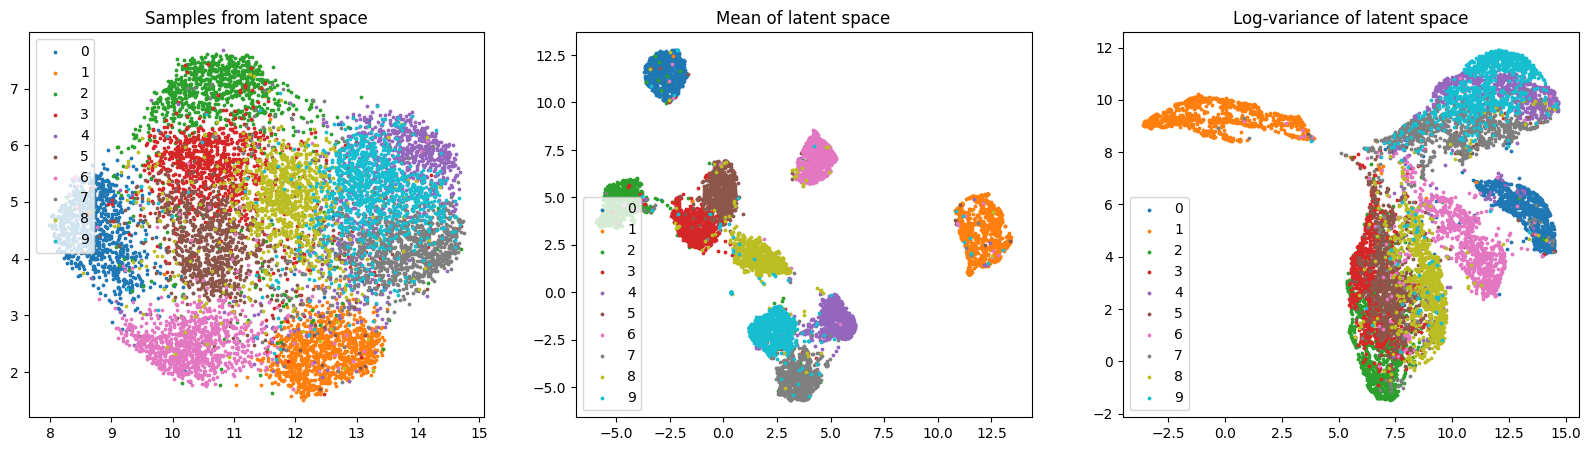

In [ ]:
# --------------------------------------------------
# Plot latent space (Dimension reduction by UMAP)
# --------------------------------------------------

# Latent sapce
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        decoded_x, mu, logvar = model(x)
        z = model.reparameterize(mu, logvar)
        if i == 0:
            z_matrix = z.cpu().detach().numpy()
            mu_matrix = mu.cpu().detach().numpy()
            logvar_matrix = logvar.cpu().detach().numpy()
            labels = y.cpu().detach().numpy()
        else:
            z_matrix = np.concatenate([z_matrix, z.cpu().detach().numpy()])
            mu_matrix = np.concatenate([mu_matrix, mu.cpu().detach().numpy()])
            logvar_matrix = np.concatenate([logvar_matrix, logvar.cpu().detach().numpy()])
            labels = np.concatenate([labels, y.cpu().detach().numpy()])

# Reduction
z_reducer = umap.UMAP(n_components = 2)
mu_reducer = umap.UMAP(n_components = 2)
logvar_reducer = umap.UMAP(n_components = 2)

z_embedding = z_reducer.fit_transform(z_matrix)
mu_embedding = mu_reducer.fit_transform(mu_matrix)
logvar_embedding = logvar_reducer.fit_transform(logvar_matrix)

# Plot
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
for num in np.unique(labels):
    ax[0].scatter(z_embedding[labels==num][:,0], z_embedding[labels==num][:,1], label = num, s = 3)
    ax[1].scatter(mu_embedding[labels==num][:,0], mu_embedding[labels==num][:,1], label = num, s = 3)
    ax[2].scatter(logvar_embedding[labels==num][:,0], logvar_embedding[labels==num][:,1], label = num, s = 3)
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'lower left')
ax[2].legend(loc = 'lower left')
ax[0].set_title("Samples from latent space")
ax[1].set_title("Mean of latent space")
ax[2].set_title("Log-variance of latent space")
plt.show()

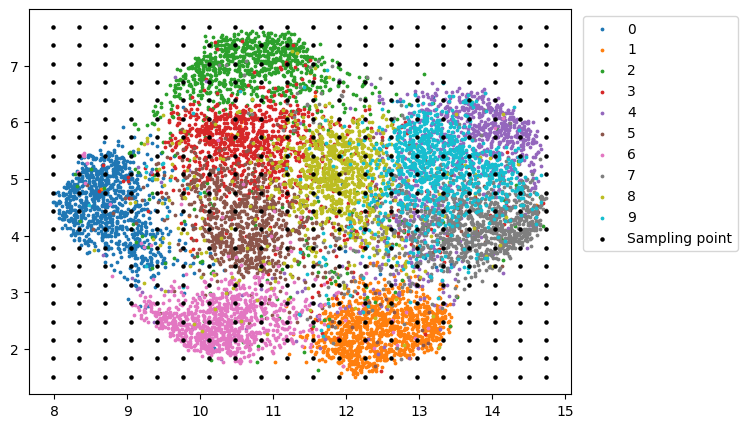

In [ ]:
# --------------------------------------------------
# Image reconstruction from latent space samples
# --------------------------------------------------

# Sampling from UMAP reduced latent spcae
y_emb = np.linspace(z_embedding[:,1].min(), z_embedding[:,1].max(), 20)[::-1]
x_emb = np.linspace(z_embedding[:,0].min(), z_embedding[:,0].max(), 20)
samples = []
for y in y_emb:
    for x in x_emb:
        samples.append([x, y])
samples = np.array(samples)

# Unreduce
z_samples = z_reducer.inverse_transform(samples)
z_samples = torch.FloatTensor(z_samples).to(device)

# Reconstrunction
model.eval()
with torch.no_grad():
    recon_image = model.decoder(z_samples)
    recon_image = recon_image.cpu().detach().numpy()

# Sampling plot
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
for num in np.unique(labels):
    ax.scatter(z_embedding[labels==num][:,0], z_embedding[labels==num][:,1], label = num, s = 3)
ax.scatter(samples[:,0], samples[:,1], color = "k", s = 5, label = 'Sampling point')
ax.legend(loc = "upper right",  bbox_to_anchor = (1.32, 1))
plt.show()

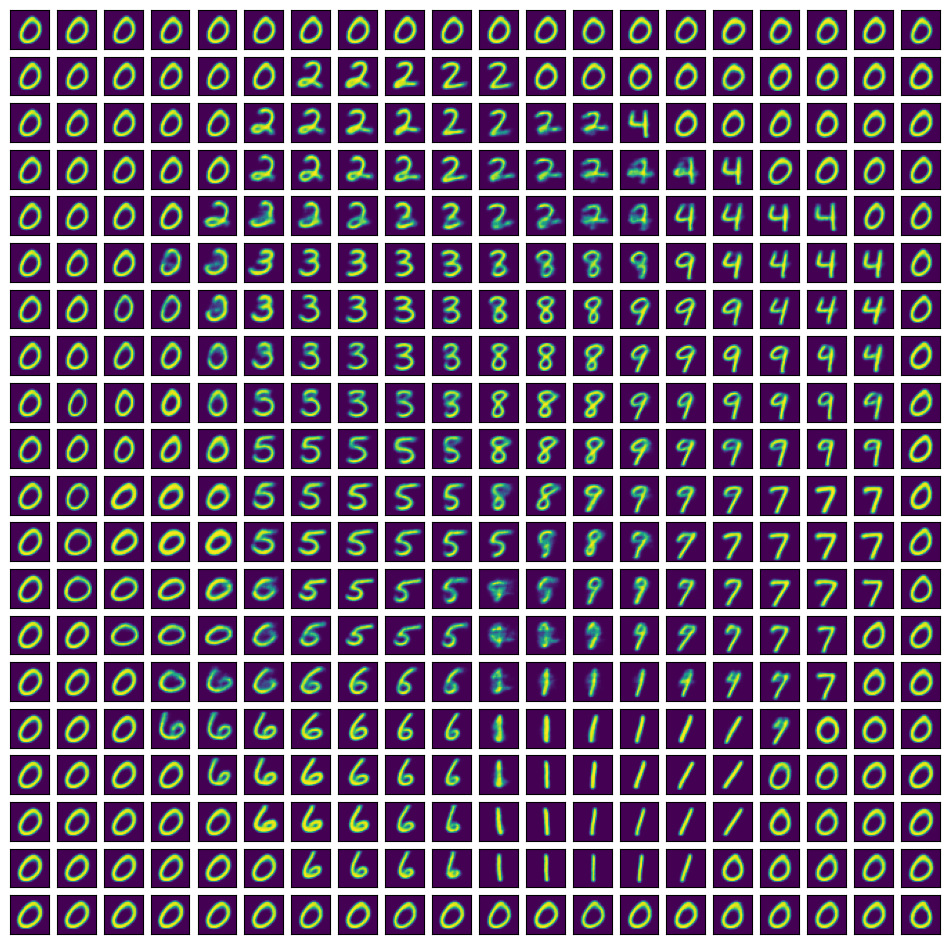

In [ ]:
# Show recostrunction images
fig, ax = plt.subplots(20, 20, figsize = (12, 12))
ax = ax.ravel()
for i in range(400):
    ax[i].imshow(recon_image[i][0])
    ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)